In [183]:
import pandas as pd
import numpy as np
import sys
import os

from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from matplotlib.patches import Patch

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

# rdkit tools
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

# Taxonomy
from ete3 import NCBITaxa

import pandas as pd
import json
from tqdm import tqdm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    nrows=0,
).columns.to_list()

['BindingDB Reactant_set_id',
 'Ligand SMILES',
 'Ligand InChI',
 'Ligand InChI Key',
 'BindingDB MonomerID',
 'BindingDB Ligand Name',
 'Target Name',
 'Target Source Organism According to Curator or DataSource',
 'Ki (nM)',
 'IC50 (nM)',
 'Kd (nM)',
 'EC50 (nM)',
 'kon (M-1-s-1)',
 'koff (s-1)',
 'pH',
 'Temp (C)',
 'Curation/DataSource',
 'Article DOI',
 'BindingDB Entry DOI',
 'PMID',
 'PubChem AID',
 'Patent Number',
 'Authors',
 'Institution',
 'Link to Ligand in BindingDB',
 'Link to Target in BindingDB',
 'Link to Ligand-Target Pair in BindingDB',
 'Ligand HET ID in PDB',
 'PDB ID(s) for Ligand-Target Complex',
 'PubChem CID',
 'PubChem SID',
 'ChEBI ID of Ligand',
 'ChEMBL ID of Ligand',
 'DrugBank ID of Ligand',
 'IUPHAR_GRAC ID of Ligand',
 'KEGG ID of Ligand',
 'ZINC ID of Ligand',
 'Number of Protein Chains in Target (>1 implies a multichain complex)',
 'BindingDB Target Chain Sequence',
 'PDB ID(s) of Target Chain',
 'UniProt (SwissProt) Recommended Name of Target Chain',

# Molecular Features

In [5]:
%autoreload 2

In [160]:
mol_df = (
    pd.read_csv(
        "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
        sep="\t",
        usecols=[
            "BindingDB Reactant_set_id",
            "Ligand SMILES",
            "BindingDB Ligand Name",
        ],
    )
    .dropna()
    .sample(10000)
)
mol_df.head()

BindingDB Reactant_set_id  \
2322687                   50940270   
782131                      799528   
1363822                    1396016   
569066                      581055   
1509459                   50126981   

                                             Ligand SMILES  \
2322687  CN1C(=O)N(Cc2cc(Cl)ccc2F)C(=O)[C@]11C(=O)N(CC(...   
782131         CNc1nc(cn2c(C)nnc12)-c1nc2ccccc2n1Cc1ccccc1   
1363822  C[C@@H](NC(=O)c1nc(no1)C(C)(C)C)c1ccc(cc1C)-c1...   
569066   CC[C@@H](O)COc1cc(-c2ccc(nc2)N2CCN(Cc3ccc(Cl)c...   
1509459  COC(=O)c1ccccc1CS(=O)(=O)N[C@H]1CCCCN(CC(=O)N[...   

                                     BindingDB Ligand Name  
2322687                                      CHEMBL2042239  
782131   US10328074, Example III-7::US11077107, Example...  
1363822                           US20240109877, Example 1  
569066   US10112942, Example 140::US10137124, Example 1...  
1509459  2-({(S)-1-[((S)-1-Carbamimidoyl-2-hydroxy-pipe...

## Chemical Properties

In [157]:
mol_df["H-Bond Donors"] = mol_df["Ligand SMILES"].apply(smiles.get_Hdonors)
mol_df["H-Bond Acceptors"] = mol_df["Ligand SMILES"].apply(smiles.get_Hacceptors)
mol_df["Molecular Weight"] = mol_df["Ligand SMILES"].apply(smiles.get_MW)
mol_df["C LogP"] = mol_df["Ligand SMILES"].apply(smiles.get_LogP)
mol_df

[13:57:15] Explicit valence for atom # 29 N, 4, is greater than permitted
[13:57:15] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[13:57:15] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[13:57:16] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:57:16] Explicit valence for atom # 18 C, 5, is greater than permitted
[13:57:18] WARNING: not removing hydrogen atom without neighbors
[13:57:18] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:57:18] Explicit valence for atom # 29 N, 4, is greater than permitted
[13:57:18] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[13:57:18] Can't kekulize mol.  Unkekulized atoms: 13 14 18
[13:57:19] Explicit valence for atom # 17 N, 4, is greater than permitted
[13:57:20] Explicit valence for atom # 18 C, 5, is greater than permitted
[13:57:22] WARNING: not removing hydrogen atom without neighbors
[13:57:22] Explicit valence for atom # 11 N, 4, is greater than permitted
[13:57:22] Explicit valence for atom # 29 N,

BindingDB Reactant_set_id  \
1408678                   50026200   
2221964                   50839547   
2814316                   51432058   
1098589                    1125233   
199979                      200000   
...                            ...   
927187                      949449   
552211                      563890   
2673675                   51291416   
624915                      639146   
461408                      468365   

                                             Ligand SMILES  \
1408678  COc1ccc(Nc2nccc(n2)-c2ccc(cc2)S(=O)(=O)N2CCNCC...   
2221964  C[NH+]1CC[C@@]23[C@H]4Oc5c2c(C[C@@H]1[C@@H]3CC...   
2814316     CCCCCCC(C)(C)c1cc(OC)c2cc(Cc3ccccc3)c(=O)oc2c1   
1098589  CCOC(=O)c1c(C)nn(c1C)-c1cc(Nc2c(C)c(nn2CC2CC2)...   
199979   Cc1cnc(N[C@H]2CCC[C@H]2OCc2ccccc2)nc1-c1c[nH]c...   
...                                                    ...   
927187   Clc1cccc(c1)-c1cc(nc2c(nccc12)-c1ccn[nH]1)N1CC...   
552211   Cc1ncc(o1)-c1cc(cnc1N)-c1cc(ccc1C)S(=O)(=O)NCC...   
2673675  Cc1cc2c(NC(=O)C#CC=C)cccc2n1-c1nc2CCCCc2c(NCc2...   
624915   CCC(CC)n1cc(cn1)-c1nc(cn2nccc12)-c1cnn(c1)C1CN...   
461408   CN1CCOc2c1c(NCC1CCN(CC3CC3)CC1)nn1c(nnc21)-c1c...   

                                     BindingDB Ligand Name H-Bond Donors  \
1408678  (4-Methoxy-phenyl)-{4-[4-(piperazine-1-sulfony...             2   
2221964                                 CHEMBL385448::DM6S             2   
2814316                                      CHEMBL2177263             0   
1098589  US11208400, Example 284::ethyl 1-[6-({1-(cyclo...             1   
199979                                           erk000608             4   
...                                                    ...           ...   
927187   4-(3-chlorophenyl)-2-(morpholin- 4-yl)-8-(1H-p...             1   
552211   3-(6-amino-5-(2- methyloxazol-5- yl)pyridin-3-...             3   
2673675                                      CHEMBL4580172             2   
624915   6-(1-(1-(methylsulfonyl)azetidin-3-yl)-1H-pyra...             0   
461408                                       US9682991, 88             1   

        H-Bond Acceptors Molecular Weight   C LogP  
1408678                7          425.514   2.4897  
2221964                6          367.423  -0.5105  
2814316                3          392.539   6.6404  
1098589               10          555.561  5.67996  
199979                 6          546.071  5.44672  
...                  ...              ...      ...  
927187                 5          391.862   4.1769  
552211                 7           430.53  2.89944  
2673675                5          461.569  5.34772  
624915                 9           454.56   2.6337  
461408                 9          517.556   4.0524  

[10000 rows x 7 columns]

## Lipinski's Rule
Lipinski's rule of five is a rule of thumb to evaluate druglikeness or determine if a chemical compound with a certain pharmacological or biological activity has chemical properties and physical properties that would likely make it an orally active drug in humans. The 
- No more than 5 H bonds donors
- No more than 10 H bond acceptors
- A molecular mass less than 500 daltons
- A calculated octanol-water partition coefficient (Clog P) that does not exceed 5

[13:57:55] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.


[13:57:56] Can't kekulize mol.  Unkekulized atoms: 1 3 6
[13:57:56] Can't kekulize mol.  Unkekulized atoms: 13 14 18


Invalid SMILES string.
Invalid SMILES string.


[13:57:57] Explicit valence for atom # 17 N, 4, is greater than permitted


Invalid SMILES string.


[13:57:59] Explicit valence for atom # 18 C, 5, is greater than permitted


Invalid SMILES string.


[13:58:04] WARNING: not removing hydrogen atom without neighbors
[13:58:04] Explicit valence for atom # 11 N, 4, is greater than permitted


Invalid SMILES string.


/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_43733/2264064302.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



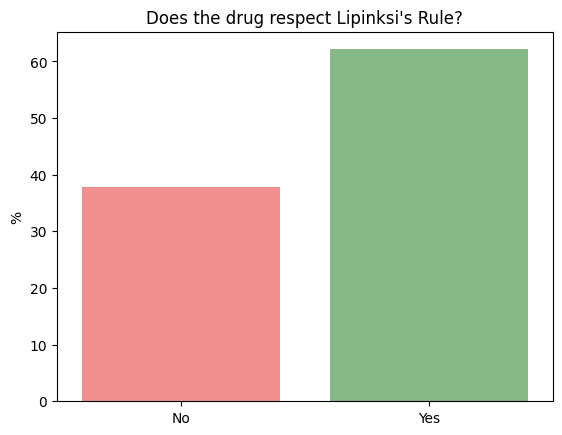

In [158]:
mol_df["Lipinski"] = mol_df["Ligand SMILES"].apply(smiles.lipinski)
ax = sns.countplot(
    mol_df,
    x="Lipinski",
    stat="percent",
    hue="Lipinski",
    palette=["#ff7f7e", "#7fc080"],
    legend=False,
)
ax.set_title("Does the drug respect Lipinksi's Rule?")
ax.set_xticklabels(["No", "Yes"])
ax.set_xlabel("")
ax.set_ylabel("%")
plt.show()

We observe a majority of drugs that respect Lipinski's rule. There are many other similar rules for druglikeness, such as Ghose filter, Veber's Rule... Other chemical properties such as number of rotatable bonds and polar surface area have been shown to influence oral bioavailability. Further analysis of the chemical features could revovle around looking into these features and rules and determining their relationship to the success metrics.

## Fingerprints

In [7]:
mol_df["Ligand Fingerprint"] = mol_df["Ligand SMILES"].apply(smiles.get_fingerprint)
str(mol_df["Ligand Fingerprint"][0].ToList())

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

A molecular fingerprint is a representation of a molecule in a digital form that allows for easy comparison with other molecules. Fingerprints capture structural information about a molecule, such as the presence of particular atoms, bonds, and functional groups, and transform this information into a series of binary values (bits) or numbers. We are using a Morgan fingerprint, a 2048 bit encoding, generated using rdkit. Using the fingerprints we can perform clustering, measure distance, and train ML models

In [99]:
plt.figure(figsize=(20, 4))
tanimoto_matrix = smiles.tanimoto_matrix(mol_df)
Z = linkage(tanimoto_matrix, method="ward")
dendrogram(Z)
plt.title("Clustering based on ligand similiarity")
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1129e2ce0>>
Traceback (most recent call last):
  File "/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [107]:
smiles_df = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "Ligand SMILES",
        "IC50 (nM)",
    ],
)
target = smiles_df[
    smiles_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
].dropna(subset=["Ligand SMILES", "IC50 (nM)"])
target["IC50 (nM)"] = (
    target["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_43733/1239991203.py:1: DtypeWarning:

Columns (9,33) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_43733/1239991203.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [167]:
smiles_df[
    "UniProt (SwissProt) Primary ID of Target Chain"
].dropna().value_counts().head()

UniProt (SwissProt) Primary ID of Target Chain
P07949    26807
O60674    25991
P00533    24060
Q06187    23249
O60885    21409
Name: count, dtype: int64

As we can see the most common target is the protein identified by the Uniprot ID: P07949. It corresponds to the Proto-oncogene tyrosine-protein kinase receptor Ret.

In [126]:
np.random.seed(24)
target["Ligand Fingerprint"] = target["Ligand SMILES"].apply(smiles.get_fingerprint)
target = target.dropna(subset="Ligand Fingerprint")
pca = PCA(n_components=3).fit(np.stack(target["Ligand Fingerprint"].dropna()))
pca_coords = pca.transform(np.stack(target["Ligand Fingerprint"].dropna()))
target[["PC1", "PC2", "PC3"]] = pca_coords

KeyboardInterrupt: 

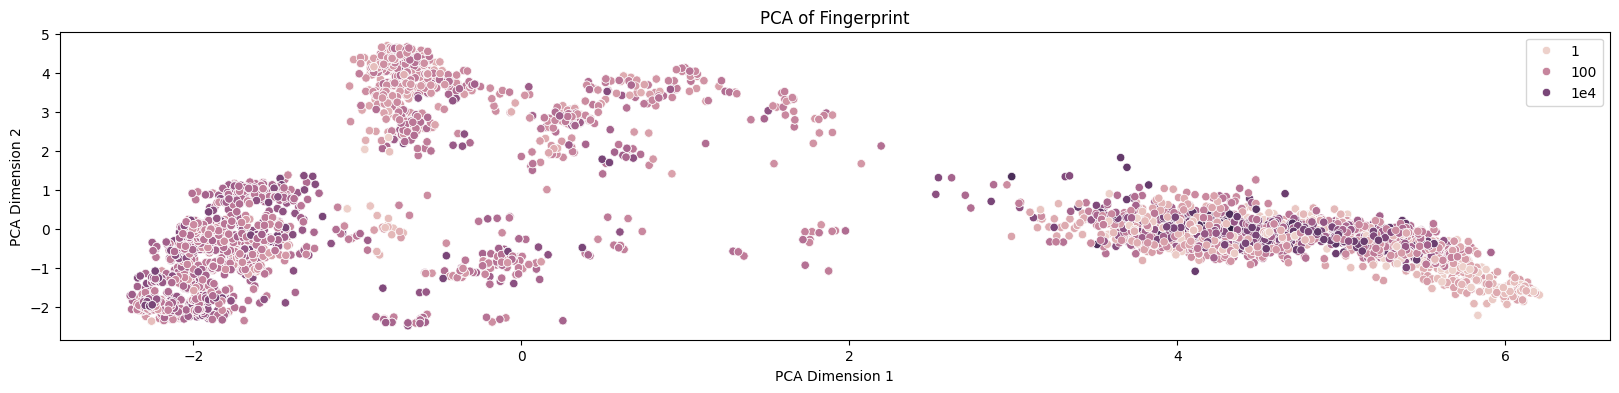

In [113]:
# Plot the PCA result
plt.figure(figsize=(20, 4))
sns.scatterplot(
    data=target[target["IC50 (nM)"] != 0],
    x="PC1",
    y="PC2",
    hue="IC50 (nM)",
    hue_norm=mcolors.LogNorm(vmin=1, vmax=target["IC50 (nM)"].max()),
)
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [130]:
np.random.seed(24)
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(
    np.stack(target["Ligand Fingerprint"].dropna())
)
target["KMeans"] = kmeans.predict(np.stack(target["Ligand Fingerprint"].dropna()))

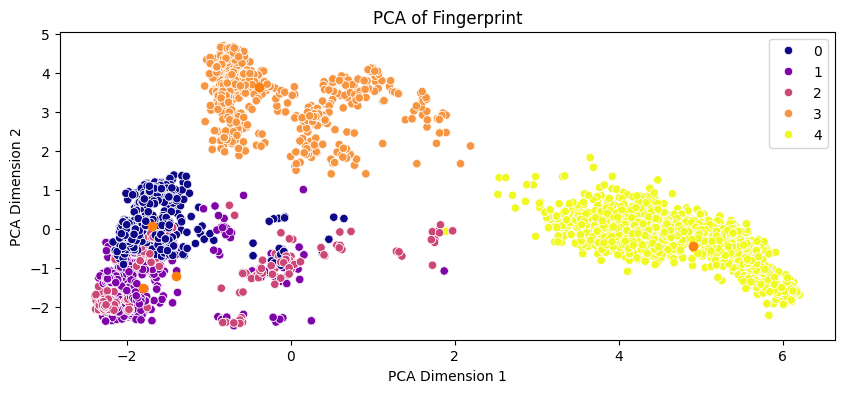

In [139]:
# Plot the PCA result
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=target,
    x="PC1",
    y="PC2",
    hue="KMeans",
    palette="plasma"
    # hue_norm=mcolors.LogNorm(vmin=1, vmax=target["IC50 (nM)"].max())
)
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [132]:
# Create the 3D scatter plot with coloring based on 'kmeans'
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=target["PC1"],
            y=target["PC2"],
            z=target["PC3"],
            mode="markers",
            marker=dict(
                size=4,
                color=target["KMeans"],  # Use 'kmeans' column for color mapping
                colorscale="thermal",  # Choose a colorscale
                colorbar=dict(title="KMeans Cluster"),  # Label the colorbar
                opacity=0.8,
            ),
        )
    ]
)

# Customize layout
fig.update_layout(
    title="3D Scatter Plot with Color Scale based on KMeans",
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"),
)

# Show the plot
fig.show()

What does the clustering mean?

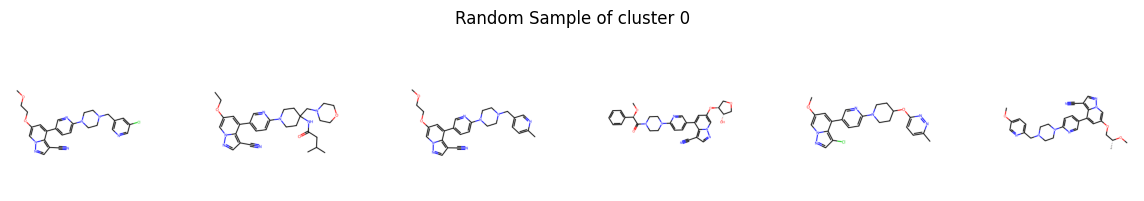

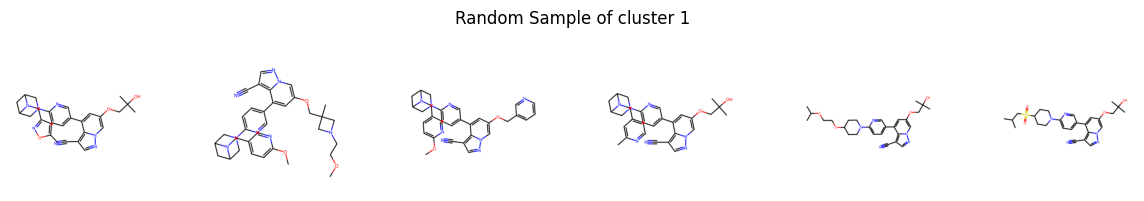

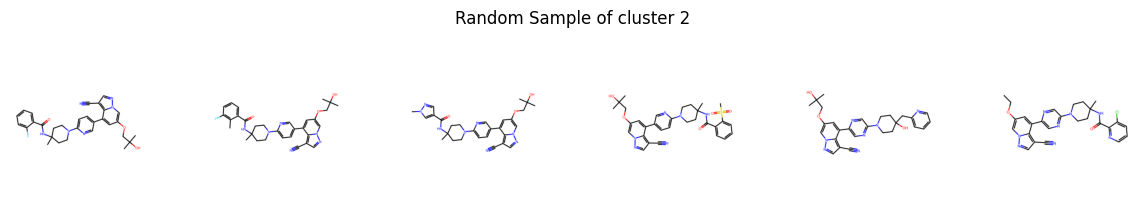

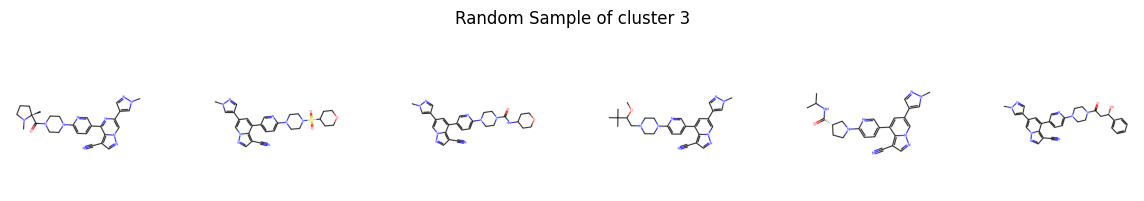

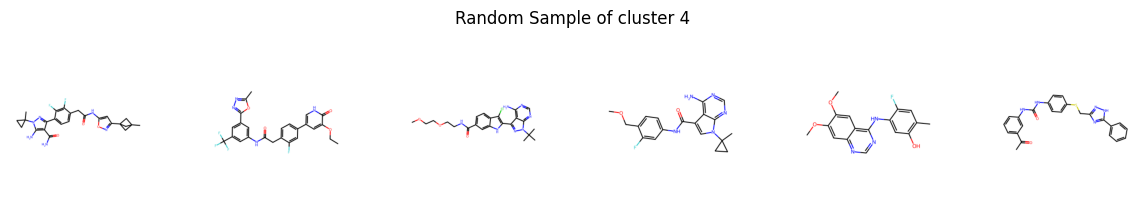

In [153]:
for i in range(5):
    smiles.show_smiles(
        target[target["KMeans"] == i],
        f"Random Sample of cluster {i}",
        n_rows=1,
        n_cols=6,
        random_sample=True,
    )

In [119]:
pd.merge(
    target.drop_duplicates("DrugBank ID of Ligand"),
    prescriptions.drop_duplicates(),
    left_on="DrugBank ID of Ligand",
    right_on="DrugBank ID of Ligand",
)

Ligand SMILES  IC50 (nM)  \
0   Fc1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)c(NC(=O)C=C)cc2...        NaN   
1   Cc1nc(Nc2ncc(s2)C(=O)Nc2c(C)cccc2Cl)cc(n1)N1CC...        NaN   
2   CN(c1ccc2c(C)n(C)nc2c1)c1ccnc(Nc2ccc(C)c(c2)S(...        NaN   
3       COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1        NaN   
4              Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1        NaN   
5   CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(c3)C(F)(F...        5.1   
6   COc1cc2c(ncnc2cc1OCCCN1CCCCC1)N1CCN(CC1)C(=O)N...        NaN   
7   C[C@@H](Oc1cc(cnc1N)-c1cnn(c1)C1CCNCC1)c1c(Cl)...        NaN   
8   C[C@@H]1CCN(C[C@@H]1N(C)c1ncnc2[nH]ccc12)C(=O)...        NaN   
9   Cc1cn(cn1)-c1cc(NC(=O)c2ccc(C)c(Nc3nccc(n3)-c3...        NaN   
10  COc1cc(Nc2c(cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)C...        NaN   
11  CN(C)C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...        NaN   
12         Oc1cc2c3c(oc(=O)c4cc(O)c(O)c(oc2=O)c34)c1O    40000.0   
13  Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)[C@@H]1C...       37.0   

   DrugBank ID of Ligand UniProt (SwissProt) Primary ID of Target Chain  \
0                DB05424                                         P07949   
1                DB01254                                         P07949   
2                DB06589                                         P07949   
3                DB08764                                         P07949   
4                DB04879                                         P07949   
5                DB08896                                         P07949   
6                DB05465                                         P07949   
7                DB08700                                         P07949   
8                DB08183                                         P07949   
9                DB04868                                         P07949   
10               DB06616                                         P07949   
11               DB08916                                         P07949   
12               DB08468                                         P07949   
13               DB09053                                         P07949   

                                   Ligand Fingerprint       PC1       PC2  \
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  4.560660  0.100654   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  3.740710  0.829107   
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.683910 -0.039708   
3   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.226753 -0.295183   
4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.457223  0.184165   
5   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.348707 -0.618819   
6   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  4.205748  0.290605   
7   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  3.913593  0.269792   
8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  3.863963  0.015693   
9   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.531686 -0.062424   
10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...  3.243027  0.333423   
11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.754143 -0.534848   
12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.316576 -0.217660   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.648282 -0.193505   

         PC3  KMeans          name  Number of Prescriptions  Units Reimbursed  \
0  -0.562959       1    canertinib                  12834.0      1.970325e+06   
1  -0.658955       1     dasatinib                 135179.0      4.429648e+06   
2   0.421388       1     pazopanib                    391.0      3.410500e+04   
3   0.732871       1    vandetanib                     37.0      2.120000e+03   
4   0.352229       1     vatalanib                     37.0      2.120000e+03   
5  -0.106460       1   regorafenib                  14705.0      1.045366e+06   
6  -0.034721       1    tandutinib                   8072.0      8.938060e+05   
7   0.749155       1    crizotinib                   7853.0      4.429600e+05   
8   0.01

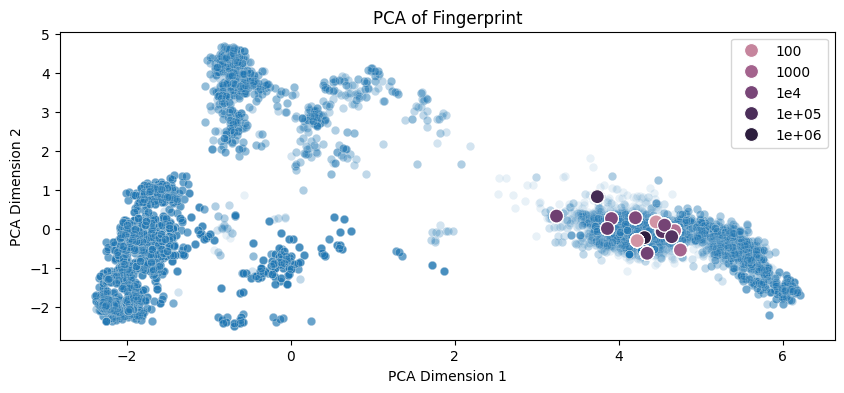

In [150]:
# Plot the PCA result
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=target,
    x="PC1",
    y="PC2",
    alpha=0.1
    # hue="KMeans",
    # palette='plasma'
    # hue_norm=mcolors.LogNorm(vmin=1, vmax=target["IC50 (nM)"].max())
)

sns.scatterplot(
    data=pd.merge(
        target,
        prescriptions,
        left_on="DrugBank ID of Ligand",
        right_on="DrugBank ID of Ligand",
    ),
    x="PC1",
    y="PC2",
    hue="Number of Prescriptions",
    hue_norm=mcolors.LogNorm(vmin=1, vmax=target["IC50 (nM)"].max()),
    s=100
    # size="Number of Prescriptions"
)
centroids = pca.transform(kmeans.cluster_centers_)
# plt.scatter(x=centroids[:,0],y=centroids[:,1])
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

In [164]:
target.dropna(subset="DrugBank ID of Ligand")

Ligand SMILES  IC50 (nM)  \
45829           Cc1ccc(O)cc1Nc1ccnc2cc(ccc12)-c1csc(C=O)n1       25.0   
64940    Cc1ccc(cc1)-n1nc(cc1NC(=O)Nc1ccc(OCCN2CCOCC2)c...        NaN   
64943    Fc1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)c(NC(=O)C=C)cc2...        NaN   
64944    Cc1nc(Nc2ncc(s2)C(=O)Nc2c(C)cccc2Cl)cc(n1)N1CC...        NaN   
64945             COCCOc1cc2ncnc(Nc3cccc(c3)C#C)c2cc1OCCOC        NaN   
...                                                    ...        ...   
2881617  CN(C)C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2...    10000.0   
2882501  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(c3)C(F)(F...        5.9   
2882502  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(c3)C(F)(F...        1.5   
2882504  CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...        7.0   
2882518  CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...       13.0   

        DrugBank ID of Ligand UniProt (SwissProt) Primary ID of Target Chain  \
45829                 DB07832                                         P07949   
64940                 DB03044                                         P07949   
64943                 DB05424                                         P07949   
64944                 DB01254                                         P07949   
64945                 DB00530                                         P07949   
...                       ...                                            ...   
2881617               DB08916                                         P07949   
2882501               DB00398                                         P07949   
2882502               DB08896                                         P07949   
2882504               DB08901                                         P07949   
2882518               DB08901                                         P07949   

                                        Ligand Fingerprint       PC1  \
45829    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.268680   
64940    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  3.969299   
64943    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  4.560660   
64944    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  3.740710   
64945    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  4.534852   
...                                                    ...       ...   
2881617  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.754143   
2882501  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.436659   
2882502  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4.348707   
2882504  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  4.078133   
2882518  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  4.078133   

              PC2       PC3  KMeans  
45829   -0.000078  0.228804       4  
64940   -0.289260 -0.371472       4  
64943    0.100649 -0.562952       4  
64944    0.829106 -0.658953       4  
64945   -0.135997  0.252206       4  
...           ...       ...     ...  
2881617 -0.534853  0.026884       4  
2882501 -0.513081 -0.205371       4  
2882502 -0.618826 -0.106456       4  
2882504  0.124882 -0.234824       4  
2882518  0.124882 -0.234824       4  

[259 rows x 9 columns]

# Sequence

In [30]:
for col in df.columns:
    print(f"'{col}',")

'Ligand SMILES',
'IC50 (nM)',
'UniProt (SwissProt) Primary ID of Target Chain',


In [6]:
seq_df = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "UniProt (TrEMBL) Submitted Name of Target Chain",
        "UniProt (SwissProt) Recommended Name of Target Chain",
        "UniProt (TrEMBL) Primary ID of Target Chain",
        "BindingDB Target Chain Sequence",
    ],
).drop_duplicates()
print(seq_df.shape)
targets.to_fasta(seq_df, filepath="BindingDB.fasta")

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_34301/4190887837.py:1: DtypeWarning: Columns (45,47) have mixed types. Specify dtype option on import or set low_memory=False.
  seq_df = pd.read_csv(


(8889, 5)


In [10]:
df["DrugBank ID of Ligand"].value_counts()

DrugBank ID of Ligand
DB01268    218
DB01254    121
DB08764    111
DB00398    102
DB05424     89
          ... 
DB07410      1
DB07873      1
DB07404      1
DB08529      1
DB01392      1
Name: count, Length: 917, dtype: int64

In [74]:
drugbank = pd.read_xml("../data/fulldatabase.xml")

In [79]:
"Dulaglutide" in pd.unique(drugbank["name"])

True

NameError: name 'ndc' is not defined

In [81]:
drugbank.columns

Index(['type', 'created', 'updated', 'drugbank-id', 'name', 'description',
       'cas-number', 'unii', 'state', 'groups', 'general-references',
       'synthesis-reference', 'indication', 'pharmacodynamics',
       'mechanism-of-action', 'toxicity', 'metabolism', 'absorption',
       'half-life', 'protein-binding', 'route-of-elimination',
       'volume-of-distribution', 'clearance', 'classification', 'salts',
       'synonyms', 'products', 'international-brands', 'mixtures', 'packagers',
       'manufacturers', 'prices', 'categories', 'affected-organisms',
       'dosages', 'atc-codes', 'ahfs-codes', 'pdb-entries', 'patents',
       'food-interactions', 'drug-interactions', 'sequences',
       'experimental-properties', 'external-identifiers', 'external-links',
       'pathways', 'reactions', 'snp-effects', 'snp-adverse-drug-reactions',
       'targets', 'enzymes', 'carriers', 'transporters', 'fda-label', 'msds',
       'average-mass', 'monoisotopic-mass', 'calculated-properties'],
 

In [23]:
drugbank_id.value_counts()

DrugBank ID of Ligand
DB00819                  2344
DB02546                  1736
DB01268                  1692
DB00398                  1660
DB05465                  1209
                         ... 
DB07291                     1
DB08143                     1
DB08140                     1
DB08139                     1
DB08353                     1
Name: count, Length: 2616, dtype: int64

# Prescription Data

In [79]:
medicaid = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/full_medicaid.csv"
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_43733/1377576603.py:1: DtypeWarning:

Columns (2,9,10,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.



In [89]:
prescriptions = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/prescription_per_drugbank_id.csv",
    index_col=0,
)

In [90]:
prescriptions

name DrugBank ID of Ligand  Number of Prescriptions  \
0               (s)-fluoxetine               DB08544              185129968.0   
1            1-benzylimidazole               DB04581                 188179.0   
2     2,5-dimethoxyamphetamine               DB01465               13120309.0   
3           2-hydroxyquinoline               DB04745                9493704.0   
4    5beta-dihydrotestosterone               DB07447                   8259.0   
..                         ...                   ...                      ...   
280                 vilazodone               DB06684              209338266.0   
281               vildagliptin               DB04876                2253755.0   
282                 viloxazine               DB09185                    195.0   
283                 vismodegib               DB08828                  11123.0   
284               zofenoprilat               DB08766                   7642.0   

     Units Reimbursed  Total Amount Reimbursed  
0        6.046571e+09             3.254190e+09  
1        1.039965e+06             6.081405e+07  
2        4.630275e+08             4.586159e+08  
3        1.706717e+07             1.853166e+07  
4        3.420970e+05             1.701221e+06  
..                ...                      ...  
280      7.124988e+09             2.395436e+09  
281      8.209390e+07             1.144728e+09  
282      9.296000e+03             6.734340e+03  
283      2.973140e+05             1.230787e+08  
284      3.913462e+04             1.184437e+06  

[285 rows x 5 columns]

In [82]:
medicaid.columns.to_list()

['Unnamed: 0.1',
 'Unnamed: 0',
 'Utilization Type',
 'NDC',
 'Labeler Code',
 'Product Code',
 'Package Size',
 'Year',
 'Quarter',
 'Suppression Used',
 'Product Name',
 'Units Reimbursed',
 'Number of Prescriptions',
 'Total Amount Reimbursed',
 'Medicaid Amount Reimbursed',
 'Non-medicaid Amount Reimbursed',
 'Record ID',
 'Supression Used',
 'Product FDA List Name']

In [71]:
medicaid[pd.isna(medicaid["No. of Prescriptions"])][
    ["Number of Prescriptions", "No. of Prescriptions"]
]

Number of Prescriptions  No. of Prescriptions
0                           12.0                   NaN
1                            NaN                   NaN
2                            NaN                   NaN
3                         5615.0                   NaN
4                         2387.0                   NaN
...                          ...                   ...
5318382                     15.0                   NaN
5318383                      NaN                   NaN
5318384                      NaN                   NaN
5318385                      NaN                   NaN
5318386                      NaN                   NaN

[4011286 rows x 2 columns]

In [61]:
medicaid.iloc[0]["No. of Prescriptions"]

nan

In [48]:
medicaid.loc[438975]  # , 'No. of Prescriptions']

KeyError: 438975

In [37]:
medicaid[medicaid["Number of Prescriptions"] > 1e6]

Unnamed: 0 Utilization Type State          NDC  Labeler Code  \
438975         1243             FFSU    XX      8084181             8   
439997         2265             FFSU    XX     29152722            29   
442252         4520             FFSU    XX     71080524            71   
448939        11207             FFSU    XX    300304613           300   
467801        30069             FFSU    XX  59930156001         59930   
...             ...              ...   ...          ...           ...   
4360212      138311             MCOU    XX  66993001968         66993   
4377479      155578             MCOU    XX     54327099            54   
4436940      215039             MCOU    XX  66993001968         66993   
4513525      291624             MCOU    XX  66993001968         66993   
5007681      166584             MCOU    XX    173068220           173   

        Product Code Package Size  Year  Quarter Suppression Used  ...  \
438975           841           81  2003        4            False  ...   
439997          1527           22  2003        4            False  ...   
442252           805           24  2003        4            False  ...   
448939          3046           13  2003        4            False  ...   
467801          1560            1  2003        4            False  ...   
...              ...          ...   ...      ...              ...  ...   
4360212           19           68  2021        3            False  ...   
4377479         3270           99  2021        2            False  ...   
4436940           19           68  2021        2            False  ...   
4513525           19           68  2021        1            False  ...   
5007681          682           20  2023        2            False  ...   

        Total Amount Reimbursed  Medicaid Amount Reimbursed  \
438975             1.374223e+08                8.723615e+07   
439997             9.872545e+07                1.068824e+06   
442252             1.653390e+08                4.047005e+07   
448939             2.054392e+08                1.015394e+08   
467801             2.079505e+07                8.643680e+06   
...                         ...                         ...   
4360212            4.763277e+07                4.736454e+07   
4377479            1.201402e+07                1.193191e+07   
4436940            4.489819e+07                4.469059e+07   
4513525            4.959803e+07                4.939793e+07   
5007681            6.480195e+07                6.458734e+07   

         Non-medicaid Amount Reimbursed  Record ID  State Code  \
438975                        191846.74        NaN         NaN   
439997                          5149.66        NaN         NaN   
442252                        261125.22        NaN         NaN   
448939                        185138.30        NaN         NaN   
467801                         27884.91        NaN         NaN   
...                                 ...        ...         ...   
4360212                             NaN        NaN         NaN   
4377479                             NaN        NaN         NaN   
4436940                             NaN        NaN         NaN   
4513525                             NaN        NaN         NaN   
5007681                             NaN        NaN         NaN   

         Supression Used Product FDA List Name No. of Prescriptions  \
438975               NaN                   NaN                  NaN   
439997               NaN                   NaN                  NaN   
442252               NaN                   NaN                  NaN   
448939               NaN                   NaN                  NaN   
467801               NaN                   NaN                  NaN   
...                  ...                   ...                  ...   
4360212              NaN                   NaN                  NaN   
4377479              NaN                   NaN                  NaN   
4436940              NaN                   NaN        

In [15]:
ids[ids["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"].index

[44870,
 45826,
 45827,
 45828,
 45829,
 45830,
 45831,
 45832,
 45833,
 45834,
 45835,
 45836,
 45837,
 45838,
 45839,
 64936,
 64937,
 64938,
 64939,
 64940,
 64941,
 64942,
 64943,
 64944,
 64945,
 64946,
 64947,
 64948,
 64949,
 64950,
 64951,
 64952,
 64953,
 64954,
 64955,
 64956,
 64957,
 64958,
 64959,
 64960,
 64961,
 64962,
 64963,
 64964,
 64965,
 64966,
 64967,
 64968,
 64969,
 64970,
 64971,
 64972,
 64973,
 64974,
 234028,
 234029,
 234030,
 234031,
 234032,
 234033,
 234034,
 234035,
 234036,
 234037,
 234038,
 234039,
 234040,
 234041,
 254301,
 263048,
 263049,
 263050,
 263051,
 263052,
 263053,
 280599,
 280600,
 280601,
 280602,
 280603,
 280604,
 280605,
 280606,
 280607,
 280608,
 280609,
 280610,
 280611,
 280612,
 280613,
 280614,
 280615,
 280616,
 342781,
 364030,
 425239,
 530788,
 530789,
 530790,
 530791,
 530792,
 530793,
 530794,
 530795,
 530796,
 530797,
 530798,
 530799,
 530800,
 530801,
 530802,
 530803,
 530804,
 530805,
 530806,
 530807,
 530808,
 

In [9]:
df = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Ligand SMILES",
        "IC50 (nM)",
    ],
)
target = df[df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"].dropna()
target["IC50 (nM)"] = (
    target["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_45469/888211649.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  ids = pd.read_csv(


In [12]:
df = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Ligand SMILES",
        "IC50 (nM)",
    ],
)
target = df[df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"].dropna()
target["IC50 (nM)"] = (
    target["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)

#####

fpgen = AllChem.GetMorganGenerator(radius=3)


def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol != None:
        return fpgen.GetFingerprint(mol).ToList()
    else:
        return np.nan


#####

target["Ligand Fingerprint"] = target["Ligand SMILES"].apply(get_fingerprint)
pca_coords = PCA(n_components=3).fit_transform(
    np.stack(target["Ligand Fingerprint"].dropna())
)
target[["PC1", "PC2", "PC3"]] = pca_coords


#####
# Plot the PCA result
plt.figure(figsize=(20, 4))
sns.scatterplot(
    data=target,
    x="PC1",
    y="PC2",
    hue="IC50 (nM)",
    hue_norm=mcolors.LogNorm(vmin=1, vmax=target["IC50 (nM)"].max()),
)
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

#####

# Create the 3D scatter plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=target["PC1"],
            y=target["PC2"],
            z=target["PC3"],
            mode="markers",
            marker=dict(
                size=2,
                colorscale="Viridis",  # Choose a colorscale
                colorbar=dict(title="Color Scale"),
                opacity=0.8,
            ),
        )
    ]
)

# Customize layout
fig.update_layout(
    title="3D Scatter Plot with Color Scale",
    scene=dict(xaxis_title="X Axis", yaxis_title="Y Axis", zaxis_title="Z Axis"),
)

# Show the plot
fig.show()

#####

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(
    np.stack(target["Ligand Fingerprint"].dropna())
)

# Plot the PCA result
plt.figure(figsize=(10, 4))
sns.scatterplot(
    data=target,
    x="PC1",
    y="PC2",
    hue="kmeans",
    # hue_norm=mcolors.LogNorm(vmin=1, vmax=target["IC50 (nM)"].max())
)
plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1])
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

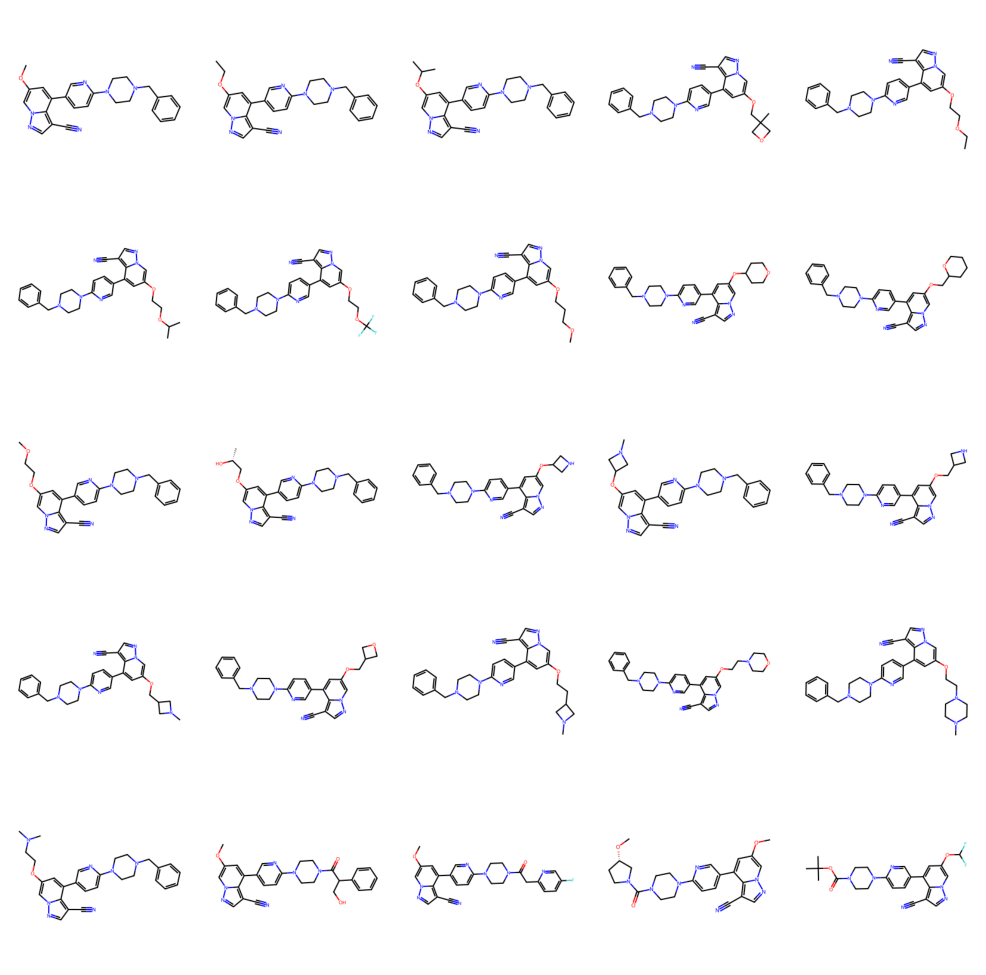

In [118]:
target["Ligand Fingerprint"]

44870      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
45826      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
45827      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
45828      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
45829      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                 ...                        
2904329    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
2906656    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2906657    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2907596    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2907597    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
Name: Ligand Fingerprint, Length: 26352, dtype: object

In [119]:
DataStructs.FingerprintSimilarity(
    target["Ligand Fingerprint"][0], target["Ligand Fingerprint"][1]
)

KeyError: 0

In [125]:
smiles_df = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    usecols=["Ligand SMILES"],
    nrows=1000,
).dropna()

In [ ]:
target_class_counts = df["Target Class"].value_counts().head(10)
# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the barplot
sns.barplot(
    x=target_class_counts.index,
    y=target_class_counts.values,
    palette="viridis",
    hue=target_class_counts.index,
    dodge=False,
    legend=False,
)


plt.xlabel("Target Class")
plt.ylabel("Count")
plt.title("Top 10 Target Classes by Count")
plt.subplots_adjust(right=0.8)
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()

In [178]:
names_df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Recommended Name of Target Chain",
        "UniProt (TrEMBL) Submitted Name of Target Chain",
    ],
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_43733/2311125445.py:2: DtypeWarning:

Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.



In [204]:
names = targets.get_name(names_df).dropna().astype(str).apply(utils.lower)
names.value_counts()[0:40]

UniProt (SwissProt) Recommended Name of Target Chain
proto-oncogene tyrosine-protein kinase receptor ret                               26815
tyrosine-protein kinase jak2                                                      26058
d(2) dopamine receptor                                                            25038
epidermal growth factor receptor                                                  24123
tyrosine-protein kinase btk                                                       23338
bromodomain-containing protein 4                                                  21417
mu-type opioid receptor                                                           21198
tyrosine-protein kinase jak1                                                      20989
acetylcholinesterase                                                              20529
nuclear receptor ror-gamma                                                        19792
potassium voltage-gated channel subfamily h member 2               

In [447]:
mapping = {
    "Growth Factor Receptor": ["gfr"],
    "CDK": ["cyclin-dependent kinase"],
    "Polyprotein": [],
    "Histone Modifications": [
        "histone deacetylase",
        "bromodomain-containing protein",
        "histone demethylase",
    ],
    "RTK": [
        "tyrosine-protein kinase receptor",
        "tyrosine kinase receptor",
        "receptor tyrosine kinase",
    ],
    "Neurotransmitter receptor": [
        "serotonin receptor",
        "dopamine receptor",
        "hydroxytryptamine receptor",
        "dopamine receptor",
        "cannabinoid receptor",
        "glutamate receptor",
    ],
    "Neurotransmitter transporter": [
        "serotonin transporter",
        "dopamine transporter",
        "acetylcholinesterase",
        "cholinesterase",
    ],
    "Neurotransmitter synthesis": ["cholinesterase", "amine oxidase"],
    "Neural Peptide Receptor": ["orexin", "hypocretin"],
    "Hormone Receptor": [
        "corticotropin-releasing factor receptor",
        "prostaglandin",
        "estrogen receptor",
        "glucocorticoid receptor",
        "insulin receptor",
        "glucagon receptor",
        "vasopressin v1a receptor",
    ],
    "Caspase": [],
    "Blood Homeostasis": ["prothrombin", "coagulation factor", "plasma kallikrein"],
    "MAPK": ["mitogen-activated protein kinase"],
    "Non Receptor Tyr Kinase": ["btk", "tyk2", "jak", "syk", "abl1", "b-raf"],
    "Other Protein Kinase": [
        "glycogen synthase kinase-3",
        "rho-associated protein kinase 2",
        "raf proto-oncogene serine/threonine-protein kinase",
        "leucine-rich repeat serine/threonine-protein kinase 2",
        "serine/threonine-protein kinase pim-1",
        "receptor-interacting serine/threonine-protein kinase 1",
    ],
    "Transcription Factor": [
        "nuclear receptor ror-gamma",
        "peroxisome proliferator-activated receptor gamma",
    ],
    "Opioid Receptor": [],
    "Ion Channel": [
        "voltage-gated channel",
        "sodium channel",
        "potassium channel",
        "cation channel",
        "anion channel",
        "calcium channel",
    ],
    "Toll-Like Receptor": [],
    "Purine Receptor": ["adenosine receptor", "purinoceptor"],
    "Beta-Secretase": [],
    "Carbonic Anhydrase": [],
    "Protease": [],
    "_Cyclin_": ["cyclin-k", "cyclin-d1", "cyclin-t1", "cyclin-h", "cyclin-c"],
    "Ubiquitin Ligase": ["ubiquitin-protein ligase"],
    "Phosphatidylinositol Kinase": ["phosphatidylinositol"],
    "Interleukin Receptor": ["interleukin-1 receptor", "interleukin"],
    "NADP Regeneration": ["isocitrate dehydrogenase"],
    "Apoptosis Regulation": [
        "induced myeloid leukemia cell differentiation protein",
        "mcl-1",
    ],
    "GTPase": [],
    "cAMP/cGMP signaling": ["phosphodiesterase"],
    "Integrase": [],
    "Complement Factor": [],
    "H3 Receptor": [],
    "Oxidase": ["cytochrome p450 3a4"],
}

mapping_large = {
    "Nervous System": ["neurotransmitter", "beta-secretase", "opioid", "neural"],
    "Cell Proliferation": ["gfr", "cdk"],
    "Transcription Control": ["histone modifications", "transcription"],
    "Virus": ["Polyprotein"],
    "Signaling": [
        "rtk",
        "signaling",
        "mapk",
        "phosphatidylinositol",
        "non receptor tyr kinase",
        "hormone",
    ],
    "Immune System": ["complement factor", "interleukin", "toll-like"],
    "Homeostasis": [],
}


mapping_1 = {
    "FGFR": ["fibroblast growth factor receptor 1"],
    "EGFR": ["epidermal growth factor receptor"],
    "CDK": ["cyclin-dependent kinase"],
    "JAK": ["jak"],
    "Polyprotein": [],
    "Neurotransmitter transmitter": [
        "serotonin transporter",
        "dopamine transporter",
        "hydroxytryptamine receptor",
    ],
    "Neurotransmitter transporter": [
        "serotonin transporter",
        "dopamine receptor",
        "acetylcholinesterase",
        "cholinesterase",
    ],
    "Neurotransmitter synthesis": ["cholinesterase"],
    "Other Neurotransmitter Associated Protein": ["acetylcholinesterase"],
    "Histone Modifications": [
        "histone deacetylase",
        "bromodomain-containing protein",
        "histone demethylase",
    ],
    "RTK": [
        "tyrosine-protein kinase receptor",
        "tyrosine kinase receptor",
        "receptor tyrosine kinase",
    ],
    "Neural Peptide Receptor": [
        "orexin receptor",
        "orexin",
        "hypocretin",
        "galanin receptor type",
    ],  # Could be merged with neurotransmiters
    "MAPK": ["mitogen-activated protein"],
    "BTK": ["btk"],
    "TYK2": ["tyk2"],
    "Caspase": [],
    "Hormone Receptor": [
        "corticotropin-releasing factor receptor",
        "estrogen receptor",
        "insulin receptor",
        "glucagon receptor",
    ],
    "Opioid Receptor": [],
    "Blood Homeostasis": ["prothrombin"],
}

SyntaxError: expression expected after dictionary key and ':' (3097567012.py, line 48)

In [448]:
map = lambda x: utils.group_categories(x, in_mapping=mapping)
map_large = lambda x: utils.group_categories(x, in_mapping=mapping_large)

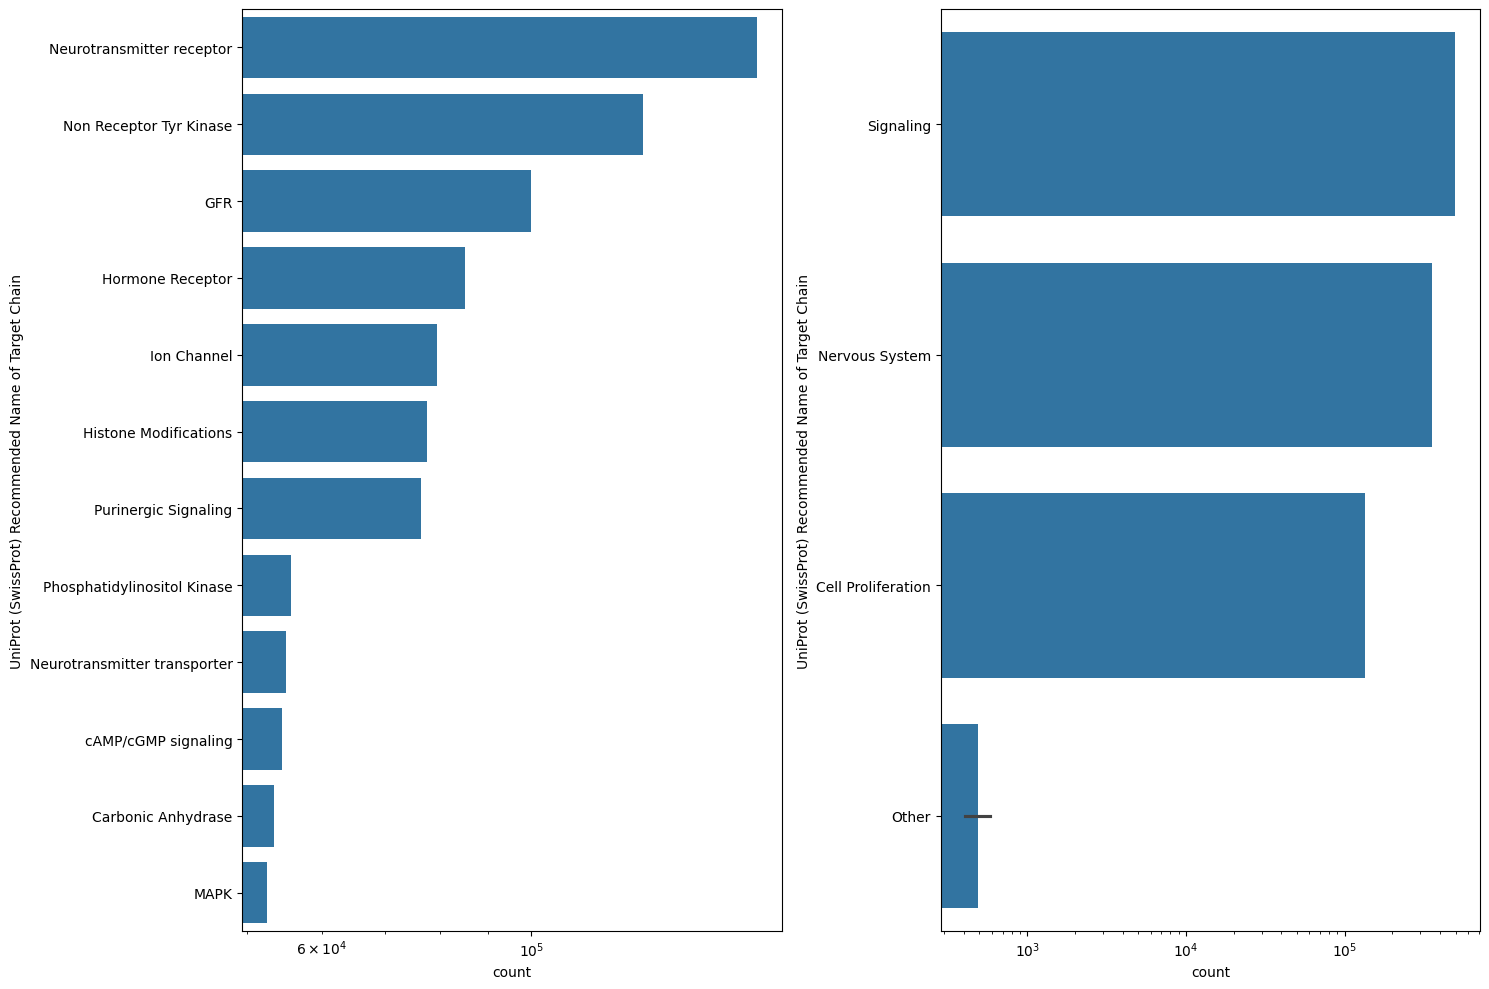

In [449]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
ax1, ax2 = axes
mapped_names = names.apply(map)
plot_df = mapped_names.value_counts().reset_index()
plot_df.loc[30:, "UniProt (SwissProt) Recommended Name of Target Chain"] = "Other"
sns.barplot(
    plot_df,
    y="UniProt (SwissProt) Recommended Name of Target Chain",
    x="count",
    order=plot_df.loc[:11, "UniProt (SwissProt) Recommended Name of Target Chain"],
    ax=ax1,
)
ax1.set_xscale("log")

mapped_names_large = mapped_names.apply(map_large)
plot_df = mapped_names_large.value_counts().reset_index()
plot_df.loc[3:, "UniProt (SwissProt) Recommended Name of Target Chain"] = "Other"
sns.barplot(
    plot_df,
    y="UniProt (SwissProt) Recommended Name of Target Chain",
    x="count",
    order=plot_df.loc[:4, "UniProt (SwissProt) Recommended Name of Target Chain"],
    ax=ax2,
)
ax2.set_xscale("log")

plt.tight_layout()
plt.show()